In [10]:
import os
import random
import numpy as np
import pandas as pd
from platypus import Problem, EpsNSGAII, Real, ProcessPoolEvaluator
from platypus import (Solution, EpsilonBoxArchive, GenerationalDistance, InvertedGenerationalDistance,
                      Hypervolume, EpsilonIndicator, Spacing, Archive)
import functools
import csv

In [4]:
# import sys
# sys.path.append(os.path.abspath(".."))
os.chdir("C:/Users/MarkW/OneDrive/Documenten/GitHub/MUSEH2O")
from susquehanna_model import susquehanna_model


In [16]:
# class TrackProgress:
#     def __init__(self):
#         self.nfe = []
#         self.improvements = []
#         self.objectives = {}

#     def __call__(self, algorithm):
#         self.nfe.append(algorithm.nfe)
#         self.improvements.append(algorithm.archive.improvements)
#         temp = []
#         for solution in algorithm.archive:
#             temp.append(list(solution.objectives))
#         self.objectives[algorithm.nfe] = temp

#     def to_dataframe(self):
#         df_imp = pd.DataFrame.from_dict(dict(nfe=self.nfe, improvements=self.improvements))
#         df_hv = pd.concat(self.objectives, axis=0)
#         return df_imp, df_hv

class TrackProgress:
    def __init__(self):
        self.nfe = []
        self.improvements = []
        self.objectives = {}

    def __call__(self, algorithm):
        self.nfe.append(algorithm.nfe)
        self.improvements.append(algorithm.archive.improvements)
        temp = {}
        for i, solution in enumerate(algorithm.archive):
            temp[i] = list(solution.objectives)
        self.objectives[algorithm.nfe] = pd.DataFrame.from_dict(temp, orient="index")

    def to_dataframe(self):
        df_imp = pd.DataFrame.from_dict(dict(nfe=self.nfe, improvements=self.improvements))
        df_hv = pd.concat(self.objectives, axis=0)
        return df_imp, df_hv    
    
track_progress = TrackProgress()

def store_results(algorithm, output_dir, base_file_name):
    header = ["hydropower", "atomicpowerplant", "baltimore", "chester", "environment", "recreation"]
    with open(f"{output_dir}/{base_file_name}_solution.csv", "w", encoding="UTF8", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(header)
        for solution in algorithm.result:
            writer.writerow(solution.objectives)

    with open(f"{output_dir}/{base_file_name}_variables.csv", "w", encoding="UTF8", newline="") as f:
        writer = csv.writer(f)
        for solution in algorithm.result:
            writer.writerow(solution.variables)

#set seed
seeds = [10] # 345, 456, 567]
# seeds = [1234, 2345] [3456, 4567, 5678]
# RBFlist = ["multiQuadric", "multiQuadric2"] #["exponential", "matern32"] # ["gaussian", "SE", "invmultiquadric", "invquadratic"]
# for RBF in RBFlist:
for seed in seeds:
    random.seed(seed)
    RBFType = "se"
    numberOfInput = 2 # (time, storage of Conowingo)
    numberOfOutput = 4  # Atomic, Baltimore,Chester, Downstream:- hydropower, environmental
    numberOfRBF = 4  # numberOfInput + 2
    # N = 2 * n * m + K * n  # check 32 with 2 inputs, 50 with 4 inputs

    # Initialize model
    nobjs = 6
    nvars = int(numberOfRBF * 8)  # 8 = 2 centers + 2 radius + 4 weights
    n_years = 1
    susquehanna_river = susquehanna_model(108.5, 505.0, 5, n_years)  # l0, l0_MR, d0, years
    # l0 = start level cono, l0_MR = start level muddy run, d0 = startday > friday = 5
    susquehanna_river.load_data(0)  # 0 = historic, 1 = stochastic
    susquehanna_river.set_log(False)

    susquehanna_river.setRBF(numberOfRBF, numberOfInput, numberOfOutput, RBFType)

    # Lower and Upper Bound for problem.types
    LB = [-1, 0, -1, 0, 0, 0, 0, 0] * numberOfRBF #+ [0, 0]
    UB = [1, 1, 1, 1, 1, 1, 1, 1] * numberOfRBF # + [np.pi * 2, np.pi * 2]
    # np.pi*2 for phaseshift upperbounds (J. Quinn Como model) check borg optimization_serial flood C model
    EPS = [0.5, 0.05, 0.05, 0.05, 0.05, 0.001]

    # platypus MOEA, no contraints
    problem = Problem(nvars, nobjs)
    # problem.types[:] = Real(-1, 1)
    problem.types[:] = [Real(LB[i], UB[i]) for i in range(nvars)]
    problem.function = susquehanna_river.evaluate  # historical (deterministic) optimization
    # problem.function = functools.partial(susquehanna_river.evaluates, opt_met=1) #way to add arguments
    # problem.function = susquehanna_river.evaluateMC  # stochastic optimization
    # problem.directions[:] = Problem.MINIMIZE
    problem.directions[0] = Problem.MINIMIZE  # hydropower
    problem.directions[1] = Problem.MINIMIZE  # atomicpowerplant
    problem.directions[2] = Problem.MINIMIZE  # baltimore
    problem.directions[3] = Problem.MINIMIZE  # chester
    problem.directions[4] = Problem.MAXIMIZE  # environment
    problem.directions[5] = Problem.MINIMIZE  # recreation

    ##added
    with ProcessPoolEvaluator() as evaluator:
        algorithm = EpsNSGAII(problem, epsilons=EPS, evaluator=evaluator)
        algorithm.run(5000, callback=track_progress)

    df_conv.to_csv(f"output/{RBFType}_{seed}_convergence2.csv")
    df_hv.to_csv(f"output/{RBFType}_{seed}_hypervolume2.csv")

    store_results(algorithm, "output", f"{RBFType}_{seed}_2")
    # results
#     print("results:")
#     for solution in algorithm.result:
#         print(solution.objectives)
#     with open(f"./output/{RBFType}_{modelseed}.pickle", "wb") as f:
#         pickle.dump(algorithm.result, f)
        # save results

#     header = ['hydropower', 'atomicpowerplant', 'baltimore', 'chester', 'environment', 'recreation']
#     with open(f'{RBFType}_{modelseed}_solution.csv', 'w', encoding='UTF8', newline='') as f:
#         writer = csv.writer(f)
#         writer.writerow(header)
#         for solution in algorithm.result:
#             writer.writerow(solution.objectives)

#     with open(f'{RBFType}_{modelseed}_variables.csv', 'w', encoding='UTF8', newline='') as f:
#         writer = csv.writer(f)
#         for solution in algorithm.result:
#             writer.writerow(solution.variables)


In [6]:
df_conv, df_hv = track_progress.to_dataframe()

In [11]:
df_conv.to_csv(f"output/{RBFType}_{seed}_convergence.csv")
df_hv.to_csv(f"output/{RBFType}_{seed}_hypervolume.csv")

store_results(algorithm, "output", f"{RBFType}_{seed}")

In [111]:
#https://github.com/Project-Platypus/Platypus/issues/71
df_imp, df_obj = track_progress.to_dataframe()
df_hv.to_csv("test.csv")

In [5]:
df_hv = pd.read_csv("test.csv")

In [11]:
df_hv.iloc[0,1]

'[-29.561950682320717, -0.14030854687773872, -0.08774643586987847, -0.11140600063577351, 0.1481376874739016, -0.8928571428571429]'

In [15]:
with ProcessPoolEvaluator(4) as evaluator:
    algorithm = EpsNSGAII(problem, epsilons=EPS, evaluator=evaluator)
    algorithm.run(1000)

INFO:Platypus:Started process pool evaluator
INFO:Platypus:Using user-defined number of processes: 4
INFO:Platypus:EpsNSGAII starting
INFO:Platypus:EpsNSGAII finished; Total NFE: 1000, Elapsed Time: 0:01:32.396103
INFO:Platypus:Closed process pool evaluator


In [127]:
# for i in algorithm.result:
#     print(i.objectives)
algorithm[0].variables

TypeError: 'EpsNSGAII' object is not subscriptable

In [16]:
# results
soll= [] 
for solution in algorithm.result:
    soll.append(solution.objectives)
# #corrosponding decision varibles:
varl = []
for solution in algorithm.result:
    varl.append(solution.variables)
# # print(varl)

print(f"{len(soll)} solutions found:")
for i in soll:
    print(i)

# with open("./output/gaussian.txt", "w") as f:
#     for solution in algorithm.result:
#         f.write("%s\n" % solution.objectives)
#     for solution in algorithm.result:
#         f.write("%s\n" % solution.variables)

# serialize results in pickle file
# with open("./output/gaussian.pickle", "wb") as f:
#     pickle.dump(algorithm.result, f)

12 solutions found:
[-8.133568166143974, -0.05168536325430313, -0.05316376765499013, -0.04228379013032747, 0.3637330856484424, -0.8928571428571429]
[-7.815032938514468, -0.016316670220005224, -0.012439606777430471, -0.007758213852241293, 0.3695243870419312, -1.0]
[-7.5563314430777, -0.02291796250256137, -0.011800066535458318, -0.011144780422842265, 0.40022385086161844, -0.9642857142857143]
[-7.05776590111464, -0.0001972081356128885, -0.0004702521047483695, -0.0005058115574124188, 0.45024352097453313, -0.8214285714285714]
[-10.644477230508537, -0.25184268367774765, -0.24230379638275218, -0.242878069915863, 0.2766050077153042, -0.9642857142857143]
[-9.421495719141252, -0.052000627613988826, -0.1788026789183237, -0.1437748533580995, 0.32946639965983887, -0.9285714285714286]
[-8.954602988002325, -0.08067990912342383, -0.060636958776585946, -0.05564795553450374, 0.3330046698132083, -1.0]
[-9.0036077675972, -0.02448002204252023, -0.048010876912318576, -0.03787481486320466, 0.3256803120351604

In [6]:
o = open("output\gaussian.pickle", "rb")
r = pickle.load(o)
for solution in r:
    print(solution.objectives)
    print(solution.variables)

In [117]:
# https://github.com/quaquel/epa1361_open/blob/master/Week%205-6%20-%20robustness%20and%20direct%20search/assignment%207%20-%20MOEA%20tutorial.ipynb
# reference_set = EpsilonBoxArchive([0.02, 0.02, 0.02])
# reference_set = EpsilonBoxArchive([0.5, 0.05, 0.05, 0.05, 0.05, 0.001])
# for x in range(1000):
#     solution = Solution(problem)
# #     solution.variables = [random.uniform(0,1) if i < problem.nobjs-1 else 0.5 for i in range(problem.nvars)]
#     variables = [random.uniform(0,1) for i in range(problem.nvars)]
#     for i in range(problem.nvars):
#         if i % 8 == 0:
#             variables[i] = random.uniform(-1,1)
#         elif (i-2) % 8 == 0:
#             variables[i] = random.uniform(-1,1)
#     solution.variables = variables
#     solution.evaluate()
#     reference_set.add(solution)
import pareto
from itertools import chain
# load solutions
sollist = []
solutions = []
for filename in os.listdir('SE_100000'):
    if filename.endswith('solution.csv'):
        sollist.append(filename[:-4])
        df_temp = pd.read_csv(f"SE_100000/{filename}", header=0)
        solutions.append(df_temp.values.tolist())
solutions = list(chain.from_iterable(solutions))
print(f"Loaded into list 'solutions': {', '.join(sollist)}")

reference_set = pareto.eps_sort([solutions], [0,1,2,3,4,5], [0.5, 0.05, 0.05, 0.05, 0.05, 0.001], maximize=[4])



Loaded into list 'solutions': SE_100_solution, SE_10_solution, SE_20_solution, SE_30_solution, SE_40_solution, SE_50_solution, SE_60_solution, SE_70_solution, SE_80_solution, SE_90_solution


In [119]:
Hypervolume(reference_set)

AttributeError: 'list' object has no attribute 'constraint_violation'

In [35]:
refsetl = []
for solution in reference_set:
    refsetl.append(solution.objectives)
print(f"{len(refsetl)} solutions found in the reference set")

44 solutions found in the reference set


In [118]:


# compute the indicators
gd = GenerationalDistance(reference_set)
print("Generational Distance:", gd.calculate(algorithm.result))

igd = InvertedGenerationalDistance(reference_set)
print("Inverted Generational Distance:", igd.calculate(algorithm.result))

hyp = Hypervolume(reference_set)
print("Hypervolume:", hyp.calculate(algorithm.result))

ei = EpsilonIndicator(reference_set)
print("Epsilon Indicator:", ei.calculate(algorithm.result))

sp = Spacing()
print("Spacing:", sp.calculate(algorithm.result))

AttributeError: 'list' object has no attribute 'constraint_violation'

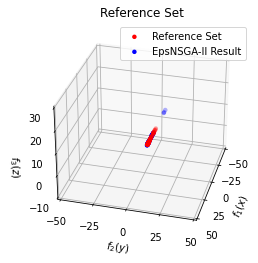

In [25]:
# plot the result versus the reference set
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter([s.objectives[0] for s in reference_set],
           [s.objectives[1] for s in reference_set],
           [s.objectives[2] for s in reference_set],
#            [s.objectives[3] for s in reference_set],
#            [s.objectives[4] for s in reference_set],
#            [s.objectives[5] for s in reference_set],
           c="red",
           edgecolors="none",
           label="Reference Set")
ax.scatter([s.objectives[0] for s in algorithm.result],
           [s.objectives[1] for s in algorithm.result],
           [s.objectives[2] for s in algorithm.result],
#            [s.objectives[3] for s in algorithm.result],
#            [s.objectives[4] for s in algorithm.result],
#            [s.objectives[5] for s in algorithm.result],
           c="blue",
           edgecolors="none",
           label = "EpsNSGA-II Result")
ax.set_title("Reference Set")
ax.set_xlim([-50, 50])
ax.set_ylim([-50, 50])
ax.set_zlim([-10, 30])
ax.set_xlabel("$f_1(x)$")
ax.set_ylabel("$f_2(y)$")
ax.set_zlabel("$f_3(z)$")
ax.view_init(elev=30.0, azim=15.0)
ax.locator_params(nbins=4)
ax.legend()
plt.show()

In [26]:
# https://plotly.com/python/plotly-express/
# https://plotly.com/python/parallel-categories-diagram/
dfl = []
for i in soll:
    dfl.append(tuple(i))
df = pd.DataFrame(dfl, columns=['Hydropower', 'AtomicPowerplant', 'Baltimore', 'Chester', 'Environment', 'Recreation'])
# df['Environment'] = df['Environment'] * -1
df = df * -1
colors = []
for i in range(len(df)):
    colors.append(i)
# df['solutions'] = colors
fig = px.parallel_coordinates(df, color="Hydropower")
fig.show()

In [19]:
# https://plotly.com/python/splom/
fig = px.scatter_matrix(df)
fig.update_traces(diagonal_visible=False)
fig.show()

NameError: name 'px' is not defined